## Introduction
Given a dataset with the following information, we will perform a marketing 
analysis on the XYZ company. Below are the following variables/features in 
the dataset:  

- ID _(int)_: customer's unique identifier
- Year_Birth _(int)_: customer's birth year
- Education _(str)_: customer's education level
- Marital_Status _(str)_: marital status (divorced, single, window, married 
etc)
- Income _(str)_: yearly household income
- Kidhome _(int)_: number of children in household
- Teenhome _(int)_: number of teenagers in household
- Dt_Customer _(datetime)_: date of enrollment
- Recency _(int)_: number of days since last purchase
- MntWines _(int)_: amount spent on wine in the last 2 years
- MntFruits _(int)_: amount spent on fruits in the last 2 years
- MntMeatProducts _(int)_: amount spent on meat in the last 2 years
- MntFishProducts _(int)_: amount spent on fish in the last 2 years
- MntSweetProducts _(int)_: amount spent on sweets in the last 2 years
- MntGoldProds _(int)_: amount spent on gold in the last 2 years
- NumDealsPurchases _(int)_: number of purchases made with a discount
- NumWebPurchases _(int)_: number of purchases made through web site
- NumCatalogPurchases _(int)_: number of purchases made using a catalogue
- NumStorePurchases _(int)_: number of purchases made directly in stores
- NumWebVisitsMonth _(int)_: number of visits to web site in the last month
- AcceptedCmp1 _(int)_: 1 if customer accepted the offer in the 1st campaign, 0 
otherwise
- AcceptedCmp2 _(int)_: 1 if customer accepted the offer in the 2nd campaign, 0 
otherwise
- AcceptedCmp3 _(int)_: 1 if customer accepted the offer in the 3rd campaign, 0 
otherwise
- AcceptedCmp4 _(int)_: 1 if customer accepted the offer in the 4th campaign, 0 
otherwise
- AcceptedCmp5 _(int)_: 1 if customer accepted the offer in the 5th campaign, 0 
otherwise
- Response _(int)_: 1 if customer accepted the offer in the last campaign, 0 otherwise
- Complain _(int)_: 1 if customer complained in the last 2 years, 0 otherwise
- Country _(str)_: location of customer

In [11]:
# Prior to analysis, we will clean the data and load modules

import numpy as np
import pandas as pd
from statsmodels.stats.power import TTestIndPower
import matplotlib.pyplot as plt
from scipy.stats import norm
from sqlalchemy import create_engine
import statsmodels.api as sm
from math import sqrt
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("display.width", 1000)

df = pd.read_csv("marketing_data.csv", sep=",")

# View data
print(df.head(1))

# View data-types
print(df.dtypes)

# Convert categorical data
df.columns = df.columns.str.strip()
df["Education"] = df["Education"].replace(["2n Cycle"], "2n_Cycle")
df["Education"] = df["Education"].astype("category")
df["Marital_Status"] = df["Marital_Status"].astype("category")
df["Country"] = df["Country"].astype("object")
df["Dt_Customer"] = pd.to_datetime(df["Dt_Customer"])

# Encode categorical predictor variables
categorical_columns = ["Education", "Marital_Status"]
for cc in categorical_columns:
    dummies = pd.get_dummies(df[cc])
    dummies = dummies.add_prefix("{}#".format(cc))
    df = df.join(dummies)

# Convert income to int
df["Income"] = df["Income"].replace({"\$": "", ",": ""}, regex=True)
df["Income"] = df["Income"].astype("float")

# Enrollment date
df["Dt_Year"] = df["Dt_Customer"].dt.year
df["Dt_Month"] = df["Dt_Customer"].dt.month
df["Dt_Day"] = df["Dt_Customer"].dt.month

# View updated dataset
print(df.head(1))

     ID  Year_Birth   Education Marital_Status      Income   Kidhome  Teenhome Dt_Customer  Recency  MntWines  MntFruits  MntMeatProducts  MntFishProducts  MntSweetProducts  MntGoldProds  NumDealsPurchases  NumWebPurchases  NumCatalogPurchases  NumStorePurchases  NumWebVisitsMonth  AcceptedCmp3  AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  Response  Complain Country
0  1826        1970  Graduation       Divorced  $84,835.00         0         0     6/16/14        0       189        104              379              111               189           218                  1                4                    4                  6                  1             0             0             0             0             0         1         0      SP
ID                      int64
Year_Birth              int64
Education              object
Marital_Status         object
 Income                object
Kidhome                 int64
Teenhome                int64
Dt_Customer            object


# Market Segmentation
Wine purchase is split into 3 categories, low, medium, high. Low wine purchase is between 0-33% of the
wine column, medium is between 33%-66%, and high is 66% or higher.
<br>
From the three graphs, as a consumer purchases more wine over the 2 year period, they also purchase more
a lot more meat, fish, and sweets. Fruits stayed relatively the same because the cost of fruits isn't too expensive.
Consumers purchasing more products may be attributed to them having a higher disposable income.


*************************
   AVG(MntWines)  AVG(MntFruits)  AVG(MntMeatProducts)  AVG(MntFishProducts)  AVG(MntSweetProducts)  AVG(MntGoldProds)  AVG(NumDealsPurchases)  AVG(NumWebPurchases)  AVG(NumCatalogPurchases)  AVG(NumStorePurchases)  AVG(NumWebVisitsMonth)  AVG(AcceptedCmp3)  AVG(AcceptedCmp4)  AVG(AcceptedCmp5)  AVG(AcceptedCmp1)  AVG(AcceptedCmp2)  AVG(Response)
0     712.190860       47.231183            335.068548             66.751344              49.895161          69.095430                2.293011              6.099462                  5.107527                8.568548                4.220430           0.092742           0.182796           0.200269           0.166667           0.032258       0.240591
0     186.165333       27.342667            143.070667             39.209333              26.124000          50.081333                2.892000              4.426667                  2.466667                5.972000                5.269333           0.053333           0.03866

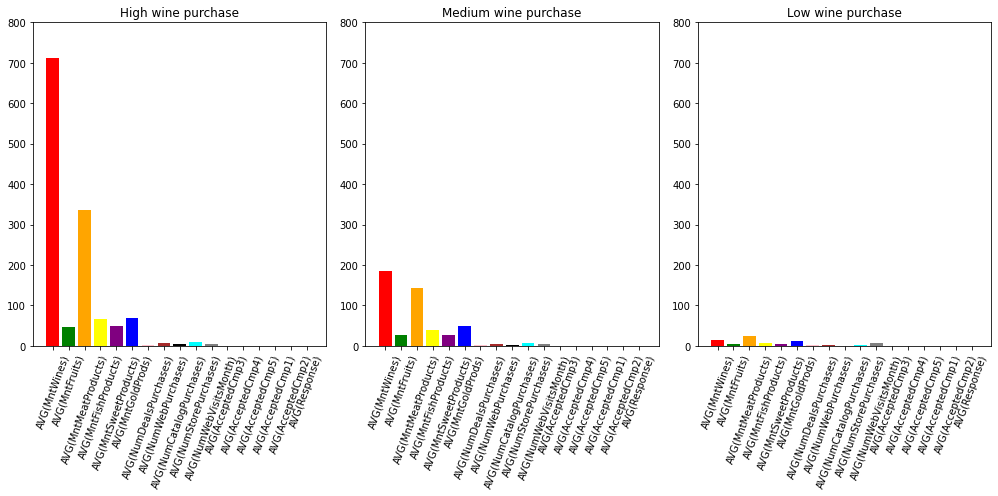

In [12]:
data = df
samples = np.array(data[['MntWines']])


def execute_sql(sql, df):
    engine = create_engine('sqlite://', echo=False)
    connection = engine.connect()
    df.to_sql(name='Marketing', con=connection, if_exists='replace', index=False)

    # This code performs the query.
    query_result = pd.read_sql(sql, connection)
    return query_result


def get_percentile_values(df):
    one_third = df['MntWines'].quantile(0.333)
    two_third = df['MntWines'].quantile(0.667)
    return one_third, two_third


def build_query(df, factorColumns):
    print("\n*************************")
    one_third, two_thirds = get_percentile_values(df)

    # Build select clause.
    select = "SELECT "
    counter = 0
    for colName in factorColumns:
        select += " AVG(" + colName + ")"
        if counter < (len(factorColumns) - 1):
            select += ","
        counter += 1
    select += " FROM Marketing "

    # Query top satisfaction summary
    sql = select + " WHERE MntWines > " + str(two_thirds)
    results1 = execute_sql(sql, df)

    # Query middle satisfaction summary
    sql = select + " WHERE MntWines >= " + str(one_third) + \
          " AND MntWines <= " + str(two_thirds)
    results2 = execute_sql(sql, df)

    # Query low satisfaction summary
    sql = select + " WHERE MntWines < " + str(one_third)
    results3 = execute_sql(sql, df)

    summary_df = results1.copy()
    summary_df = summary_df.append(results2)
    summary_df = summary_df.append(results3)
    print(summary_df)
    return results1, results2, results3


factor_columns = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
                 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
                 'NumWebVisitsMonth', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2',
                 'Response']

colours = ['red', 'green', 'orange', 'yellow',
          'purple', 'blue', 'pink', 'brown',
          'black', 'cyan', 'gray']

sub_df = data[factor_columns]
high, medium, low = build_query(sub_df, factor_columns)

# Show attribute plots for different satisfaction ranges.
plt.subplots(nrows=1, ncols=3, figsize=(14, 7))

# High satisfaction.
plt.subplot(1, 3, 1)
high_transposed = high.T.reset_index()
plt.bar(high_transposed['index'], high_transposed[0], color=colours)
plt.title("High wine purchase")
plt.ylim(0, 800)
plt.xticks(rotation=70)

# Medium satisfaction.
plt.subplot(1, 3, 2)
med_transposed = medium.T.reset_index()
plt.bar(med_transposed['index'], med_transposed[0], color=colours)
plt.title("Medium wine purchase")
plt.ylim(0, 800)
plt.xticks(rotation=70)

# Low satisfaction.
plt.subplot(1, 3, 3)
low_transposed = low.T.reset_index()
plt.bar(low_transposed['index'], low_transposed[0], color=colours)
plt.title("Low wine purchase")
plt.ylim(0, 800)
plt.xticks(rotation=70)
plt.tight_layout()
plt.show()

# Monte Carlo
A Monte Carlo simulation is done to perform a risk / reward analysis 
with random values from known distributions. We will be using our target 
column `MntWines` to generate this simulation. 

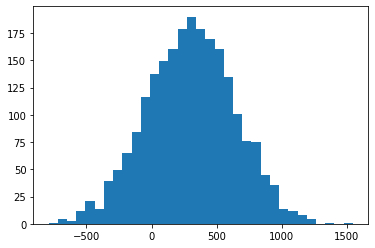

=========Monte Carlo Simulation=========
      ID  Year_Birth   Education Marital_Status   Income  Kidhome  Teenhome Dt_Customer  Recency  MntWines  MntFruits  MntMeatProducts  MntFishProducts  MntSweetProducts  MntGoldProds  NumDealsPurchases  NumWebPurchases  NumCatalogPurchases  NumStorePurchases  NumWebVisitsMonth  AcceptedCmp3  AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  Response  Complain Country  Education#2n_Cycle  Education#Basic  Education#Graduation  Education#Master  Education#PhD  Marital_Status#Absurd  Marital_Status#Alone  Marital_Status#Divorced  Marital_Status#Married  Marital_Status#Single  Marital_Status#Together  Marital_Status#Widow  Marital_Status#YOLO  Dt_Year  Dt_Month  Dt_Day  MntWineSpent
0   1826        1970  Graduation       Divorced  84835.0        0         0  2014-06-16        0       189        104              379              111               189           218                  1                4                    4                  6     

In [13]:
# Target variable is MntWines, obtaining median and sd
num_simulations = len(data)
mnt_wines_expected = data[['MntWines']].mean()
mnt_wines_sd = data[['MntWines']].std()

wine_spent = norm.rvs(loc=mnt_wines_expected, scale=mnt_wines_sd, 
                      size=num_simulations)

df_mc = pd.DataFrame(columns=["MntWineSpent"])

plt.hist(wine_spent, bins='auto')
plt.show()

for i in range(num_simulations):
    dictionary = {"MntWineSpent": round(wine_spent[i], 2)}
    df_mc = df_mc.append(dictionary, ignore_index=True)

data = pd.concat([data, df_mc], axis=1, join="inner")
print("=========Monte Carlo Simulation=========")
print(data.head(10))
print("========================================")

# Conjoint
The purpose of this survey was to figure out what factors are most important to consumers when
buying wine. The following table are the parameters chosen for the survey.

| Location        | Purchase           | Container  |
| ------------- |:-------------:| -----:|
| Canadian     | Price | bottle |
| Foreign     | Review      |   box|
| BC VQA | Quality     |    bag |

                            OLS Regression Results                            
Dep. Variable:                   Rank   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.956
Method:                 Least Squares   F-statistic:                     29.67
Date:                Fri, 16 Apr 2021   Prob (F-statistic):             0.0330
Time:                        01:59:00   Log-Likelihood:                -1.0583
No. Observations:                   9   AIC:                             16.12
Df Residuals:                       2   BIC:                             17.50
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  2.5000      0

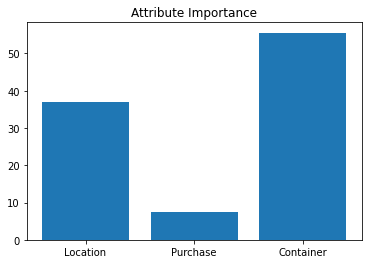

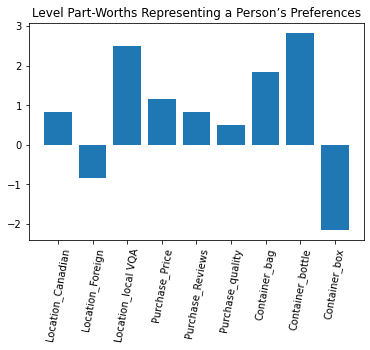

In [14]:
# read in conjoint survey profiles with respondent ranks
df_survey = pd.read_csv('survey_results.csv')

# This performs a weighted regression for ranking with string variables as
# levels.
attribute_names = [ 'Location', 'Purchase', 'Container']

y = df_survey[['Rank']]
X = df_survey[attribute_names]
X = pd.get_dummies(X, columns=attribute_names )
X = sm.add_constant(X)

lr_model = sm.OLS(y, X).fit()
print(lr_model.summary())

counter     = 0
level_names  = list(X.keys())# Level names are taken directly from X column names.
level_names.pop(0)           # Remove constant for intercept.
ranges      = []

# Store all part-worth (utility) values in a list.
# The values are taken directly from the model coefficients.
utilities   = list(lr_model.params)
utilities.pop(0)            # Removes the intercept value.

# Iterate through all attributes to create part-worths.
for attribute_name in attribute_names:
    part_worths = []

    # Iterate through all levels.
    for level_name in level_names:
        # If level name contains the attribute store the part worth.
        if attribute_name in level_name:
            part_worth = utilities[counter] 
            # Store corresponding model coefficient.
            print(" :", level_name + ": " + str(part_worth))
            part_worths.append(part_worth)
            counter += 1

    # Summarize utility range for the attribute.
    part_worth_range = max(part_worths) - min(part_worths)
    ranges.append(part_worth_range)

# Calculate relative importance scores for each attribute.
importances = []
for i in range(0, len(ranges)):
    importance = 100*ranges[i]/sum(ranges)
    importances.append(importance)
    print(attribute_names[i] + " importance: " + str(importance))

# Show the importance of each attribute.
plt.bar(attribute_names, importances)
plt.title("Attribute Importance")
plt.show()

# Show user's preference for all levels.
plt.bar(level_names, utilities)
plt.title("Level Part-Worths Representing a Person’s Preferences")
plt.xticks(rotation=80)
plt.show()

The results of the survey shows that Container is the most important factor taken into consideration
when making a wine purchase. Location of the wine is the second most
important factor.
<br>
This survey represents the team really as we both find container type to be the most important factor.
The results from this survey can potentially benefit companies who want to find out what
potential customers are looking for.

## A/B Testing
This section performs A/B testing on the amount of wine purchased and Income
<br> ----<br>
Hypothesis <br>
H0: A consumer's income has no impact on money spent on wine.
<br>
H1: When a consumer's income is increased from an average of $45,488 to \$70,515, they will
purchase more wine.

Split data into 3 groups based on the MntWine column.

In [15]:
df_wine = df["MntWines"]
first_third = df_wine.max() * 0.33
second_third = df_wine.max() * 0.66
max_wine = df_wine.max()
min_wine = df_wine.min()
df_first = df[df['MntWines'] < first_third]
df_first = df_first['Income']
df_second = df[(df['MntWines'] > first_third) & (df['MntWines'] < second_third)]
df_second = df_second['Income']
df_third = df[df['MntWines'] > second_third]
df_third = df_third['Income']

Calculate the Cohen d value. The result of this is how many sample we need to calculate the p value.

In [16]:
cohen = ((df_first.mean() - second_third.mean()) / (sqrt((df_first.std() ** 2 + df_second.std() **2) / 2)))
effect = cohen # Obtained from previous step.
alpha = 0.05  # Enable 95% confidence for two tail test.
power = 0.95  # One minus the probability of a type II error.

# Limits possibility of type II error to 20%.
analysis = TTestIndPower()
num_samples_needed = analysis.solve_power(effect, power=power, alpha=alpha)
print(num_samples_needed)

6.0865228316807505


Calculate P value with the required sample size (cohen d value)

In [17]:
old_menu_list = []
new_menu_list = []
old_menu_sales = [list(df_first.sample(n=6))]
for i in (old_menu_sales[0]):
    old_menu_list.append(i)
new_menu_sales = [df_third.sample(n=6).tolist()]
for i in new_menu_sales[0]:
    new_menu_list.append(i)

testResult = stats.ttest_ind(new_menu_list, old_menu_list, equal_var=False)

print("Hypothesis test p-value: " + str(testResult))
print("New mean: " + str(np.mean(new_menu_sales)))
print("New std: " + str(np.std(new_menu_sales)))

Hypothesis test p-value: Ttest_indResult(statistic=3.442238703031309, pvalue=0.007127614873122413)
New mean: 70003.5
New std: 12081.507366632692


With the p value being less than 0.05, we can reject the null hypothesis which says wine
purchased is not related to consumer's income.